# Mapping Twitter Data
This notebook provides the basis for developing spatial representations of a variety of interesting data that is presented in the Ferguson Twitter dataset.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import json
import time
import pandas as pd
import cartopy.crs as ccrs
from ipywidgets import widgets

Let's begin with the data. We have two datasets. The first is data from the two weeks following the initial shooting. The second is data from the two weeks following the indictment. Twitter has provided an extensive amount of data for us, and we have developed a cleaning mechanism which can be observed in a seperate script. The data is placed in a data frame:

In [3]:
def make_frame(filename,low_bound,high_bound):
    data = []
    i = 0
    #For now only want to read in a few lines of this file (about 100000 tweets)
    start = time.time()
    with open(filename) as cleanedTweets:
        for tweet in cleanedTweets:
            i += 1
            if i > low_bound and i < high_bound:
                jsonline = json.loads(tweet)
                data.append(jsonline)
            elif i > high_bound:
                break
    return data

In [13]:
filename='./data/cleanedShootingTweets.json'
data = make_frame(filename,100000,200000)
df = pd.DataFrame(data=data)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9998
Data columns (total 59 columns):
contributors                            0 non-null object
coordinates                             63 non-null object
created_at                              9999 non-null object
entities_hashtags_0_text                0 non-null float64
entities_hashtags_1_text                0 non-null float64
entities_hashtags_2_text                0 non-null float64
entities_hashtags_3_text                0 non-null float64
entities_hashtags_4_text                0 non-null float64
entities_hashtags_5_text                0 non-null float64
entities_hashtags_6_text                0 non-null float64
entities_hashtags_7_text                0 non-null float64
entities_hashtags_8_text                0 non-null float64
entities_hashtags_9_text                0 non-null float64
entities_user_mentions_0_id_str         0 non-null float64
entities_user_mentions_0_screen_name    0 non-null float64
entitie

There are several fields which we find particularly interesting here, namely the time and all place related fields. To better help us process this data in this notebook, we create new columns which breaks out created_at, coordinates and place.

In [14]:
#time based recodes
df['DoW'] = df['created_at'].apply(lambda x: str(x)[0:3:])
df['Month'] = df['created_at'].apply(lambda x: str(x)[4:7:])
df['DoM'] = df['created_at'].apply(lambda x: str(x)[8:10:])
df['Hour'] = df['created_at'].apply(lambda x: int(str(x)[11:13:]))
df['Minute'] = df['created_at'].apply(lambda x: int(str(x)[14:16:]))

#let's grab the coordinates from the coordinates field, which is actually a dictionary
coords = []
for i in range(len(df)):
    location = df['coordinates'][i]
    try: #want to make sure that null values don't throw an exception
        coords.append(location.get('coordinates'))
    except:
        coords.append([0,0])

df['Coords'] = coords
df['x'] = df['Coords'].apply(lambda x: x[0])
df['y'] = df['Coords'].apply(lambda x: x[1])

#now, let's grab the information from place, which is similarly a very detailed dictionary of elements
name = []
country = []
coordinates = []
full_name = []
for i in range(len(df)):
    location = df['place'][i]
    try:
        coordinates.append(location.get('bounding_box').get('coordinates'))
        name.append(location.get('name'))
        full_name.append(location.get('full_name'))
        country.append(location.get('country'))
    except:
        coordinates.append([[[0,0],[0,0],[0,0],[0,0]]])
        name.append('')
        full_name.append('')
        country.append('')

mean_coords = []
for box in coordinates:
    mean_coord_x = (box[0][0][0]+box[0][1][0]+box[0][2][0]+box[0][3][0])/4
    mean_coord_y = (box[0][0][1]+box[0][1][1]+box[0][2][1]+box[0][3][1])/4
    mean_coords.append([mean_coord_x,mean_coord_y])

df['city'] = name
df['country'] = country
df['full_name'] = full_name
df['P_Coords'] = mean_coords
df['x_p'] = df['P_Coords'].apply(lambda x: x[0])
df['y_p'] = df['P_Coords'].apply(lambda x: x[1])


Now that the data is all set, let's start looking at it. Using a library called [cartopy](http://scitools.org.uk/cartopy/), we can grab a really simple map to use to put everything in perspective.

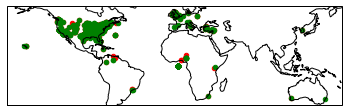

In [15]:
#the cartopy map, going simple outline for now
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

#straight-up coordinate data which we just finished recoding
plt.scatter(df.x,df.y,color='r')
plt.scatter(df.x_p,df.y_p,color='g')

plt.show()

Now, to add a temporal element to this, we add a slider which pulls in some of the time columns we also just pulled out of interest.

In [39]:
def plotLocation(Hour,Minute):
    plt.figure(figsize=(15,15))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    plt.scatter(df.x[(df['Hour']==Hour) & (df['Minute']==Minute)],df.y[(df['Hour']==Hour) & (df['Minute']==Minute)],color='r')
    plt.scatter(df.x_p[(df['Hour']==Hour) & (df['Minute']==Minute)],df.y_p[(df['Hour']==Hour) &  (df['Minute']==Minute)],color='g')
    plt.axis([-180, 180, -75, 75])

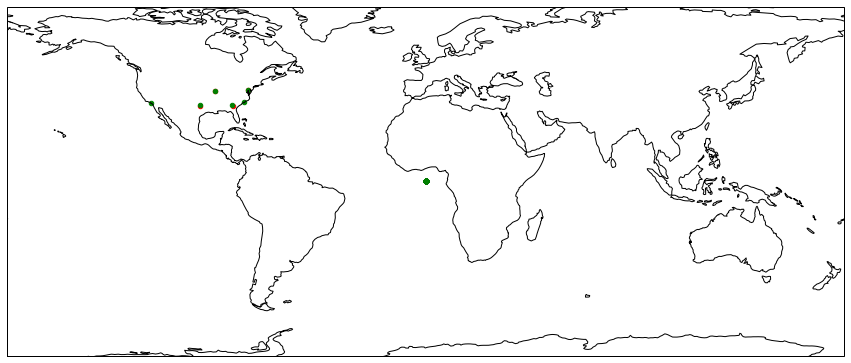

In [40]:
Hour = widgets.IntSlider(min=0, max=23, value=21)
Minute = widgets.IntSlider(min=0, max=59, value=7)
widgets.interact(plotLocation,Hour=Hour,Minute=Minute)